## **Contents**
-  [Introduction](#i)
-  [1.Importing Libraries](#1)
-  [2.Helper Functions](#2)
-  [3.Dataset Managament](#3)
    -  [3.1.Dataset and DataLoaders](#3.1)
    -  [3.2.Visualizing Dataset](#3.2)
-  [4.Initializing pre-trained model](#4)
-  [5.Training](#5)
-  [6.Plotting Graphs](#6)
    -  [6.1.Plotting Loss vs Epoch](#6.1)
-  [7.Loading and Testing](#7)

## **Introduction** <a class="anchor" id="i"></a>


In this notebook I am visualizing the dataset and also fine-tuning pre-trained [Mask-RCNN](https://arxiv.org/abs/1703.06870) model using [Pytorch](https://pytorch.org/) library.Mask R-CNN is a popular deep learning instance segmentation technique that performs pixel-level segmentation on detected objects.

The Mask R-CNN algorithm can accommodate multiple classes and overlapping objects.Mask R-CNN extends Faster R-CNN to solve instance segmentation tasks. It achieves this by adding a branch for predicting an object mask in parallel with the existing branch for bounding box recognition. In principle, Mask R-CNN is an intuitive extension of Faster R-CNN, but constructing the mask branch properly is critical for good results. 

Instance segmentation treats multiple objects of the same class as distinct individual instances which give this model slight advantage over other Semantic segmentation models. 


Read more about Mask-RCNN [here](https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/)

Some of the helper functions and dataloader classes are the derivatives of [this](https://www.kaggle.com/julian3833/sartorius-starter-torch-mask-r-cnn-lb-0-173#%F0%9F%A6%A0-Sartorius---Starter-Torch-Mask-R-CNN) notebook.

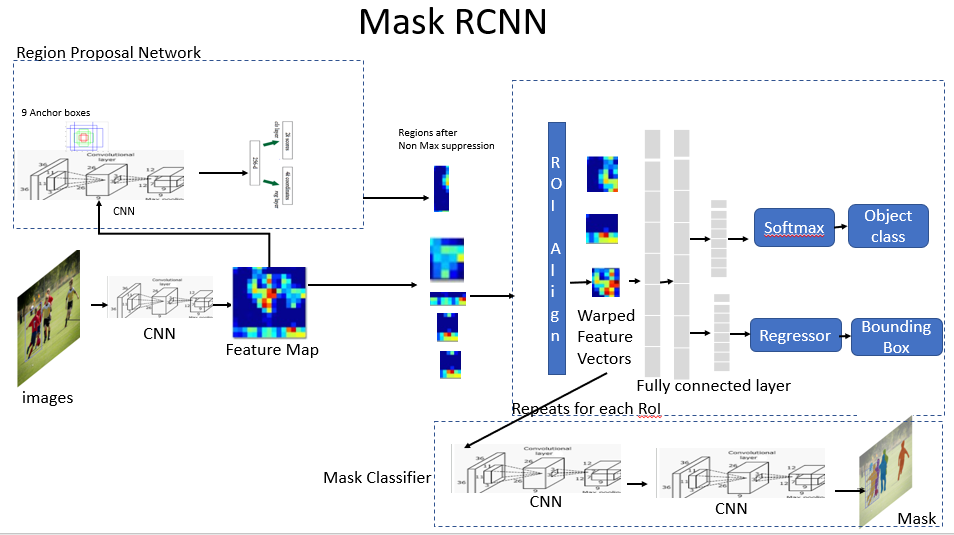

### **1.Importing Libraries** <a class="anchor" id="1"></a>

In [ ]:
import os
import sys
import torch
import random
import numpy as np
import torchvision
import pandas as pd
import seaborn as sns
from PIL import Image
from PIL import Image
from sklearn import cluster
import matplotlib.pyplot as plt
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

sys.path.append("../input/maskrcnn-utils/")
from transforms import ToTensor, RandomHorizontalFlip, Compose

torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("darkgrid")

### **2.Helper Functions** <a class="anchor" id="2"></a>

In [ ]:
IMG_W ,IMG_H = 520, 704
root = "../input/sartorius-cell-instance-segmentation/"

def rle_decode(mask_rle, shape, color=1):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

def test_model(model, dataloader,n):
    
    for i in range(n):
        fig = plt.figure(figsize=(10,10))
        img, targets = next(iter(dataloader))
        img = img[0]
        targets = targets[0]
        plt.imshow(img.numpy().transpose((1,2,0)))
        plt.grid(None)
        plt.title(f"Image : {i}")
        plt.show()
    
        fig = plt.figure(figsize=(10,10))
        all_masks = np.zeros((IMG_W ,IMG_H))
        for mask in targets['masks']:
            all_masks = np.logical_or(all_masks, mask)
        plt.imshow(img.numpy().transpose((1,2,0)))
        plt.imshow(all_masks, alpha=0.3)
        plt.grid(None)
        plt.title(f"Target : {i}")
        plt.show()
    
        fig = plt.figure(figsize=(10,10))
        model.eval()
        with torch.no_grad():
            preds = model([img.to(device)])[0]

        plt.imshow(img.cpu().numpy().transpose((1,2,0)))
        all_preds_masks = np.zeros((IMG_W ,IMG_H))
        for mask in preds['masks'].cpu().detach().numpy():
            all_preds_masks = np.logical_or(all_preds_masks, mask[0])
        plt.imshow(all_preds_masks, alpha=0.4)
        plt.grid(None)
        plt.title(f"Predictions : {i}")
        plt.show()
        


# Stolen from: https://www.kaggle.com/arunamenon/cell-instance-segmentation-unet-eda
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# Modified by me

def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def does_overlap(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            return True
    return False


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

### **3.Dataset Managament** <a class="anchor" id="3"></a>

#### 1.Downloading and Extracting Dataset <a class="anchor" id="3.1"></a>

In [ ]:
class SatoriusDataset(torch.utils.data.Dataset):
    def __init__(self, transforms, root = 'data/',train = True):
        self.root = root
        self.transforms = transforms
        self.w , self.h = 520 , 704
        info = pd.read_csv(self.root+'train.csv')[["id","annotation"]]
        info = info.groupby('id')['annotation'].agg(lambda x: list(x)).reset_index()
        validation =  6
        self.data_info = 0

        if train == True:
            self.data_info = info[validation:].reset_index(drop=True)
        else:
            self.data_info = info[:validation].reset_index(drop=True)
            
    def __getitem__(self, idx):
        img = Image.open(self.root+'train/'+self.data_info['id'][idx]+'.png').convert("RGB")
        mask = np.zeros((len(self.data_info['annotation'][idx]), self.w, self.h), dtype=int)
        
        num_objs = len(self.data_info['annotation'][idx])
        
        for i in range(num_objs):
            nth_mask = rle_decode(self.data_info['annotation'][idx][i], (self.w, self.h))
            nth_mask = np.array(nth_mask) > 0
            mask[i, :, :] = nth_mask
    

        
        boxes = []
        new_masks = []

        for i in range(num_objs):
            pos = np.where(mask[i, :, :])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            new_masks.append(mask[i, :, :])
        
        nmx = np.zeros((num_objs ,self.w, self.h), dtype=int)
        
        for i in range(num_objs):
            nmx[i, :, :] = new_masks[i]
        
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(nmx, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img,target = self.transforms(img,target)
            
        return img, target

    def __len__(self):
        return len(self.data_info)


    
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)


train_dataset = SatoriusDataset(transforms=get_transform(train=True),root =root,train = True)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

validation_dataset = SatoriusDataset(transforms=get_transform(train=False),root =root,train = False)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

#### 2.Visualizing Dataset <a class="anchor" id="3.2"></a>

In [ ]:
train_df = train_dataset.data_info
validation_df = validation_dataset.data_info

pd.set_option('max_colwidth', 125)
display(train_df.head())
display(validation_df)

In [ ]:
sns.set_palette("pastel")

n_annotations = [[],[]] #[[train], [validation]]
for i in train_df['annotation']:
    n_annotations[0].append(len(i))
    
for i in validation_df['annotation']:
    n_annotations[1].append(len(i))

x_axis,y_axis = 'Number Of Annotations' , 'Number Of Images'

fig = plt.figure(figsize=(8,8))
p = sns.histplot(data = n_annotations[0])
p.set_xlabel(x_axis, fontsize = 15)
p.set_ylabel(y_axis, fontsize = 15)


plt.show()

fig = plt.figure(figsize=(8,8))
p = sns.histplot(data = n_annotations[1])
p.set_xlabel(x_axis, fontsize = 15)
p.set_ylabel(x_axis, fontsize = 15)
plt.show()

In [ ]:
import cv2

img, targets = next(iter(validation_dataloader))
image = np.array(img[0])
targets = targets[0]
image = cv2.cvtColor(image.transpose((1,2,0)), cv2.COLOR_BGR2RGB)
all_masks = np.zeros((IMG_W ,IMG_H))
for mask in targets['masks']:
    all_masks = np.logical_or(all_masks, mask)
    
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(all_masks, alpha=0.5)
plt.axis("off")
plt.figure(figsize=(10, 10))
plt.imshow(all_masks)
plt.axis("off")
    
plt.show()

In [ ]:
def clustered_img(x):
    kmeans = cluster.KMeans(2)
    dims = np.shape(x)
    pixel_matrix = np.reshape(x, (dims[0] * dims[1], dims[2]))
    clustered = kmeans.fit_predict(pixel_matrix)
    clustered_img = np.reshape(clustered, (dims[0], dims[1]))
    return clustered_img

for i in range(2):
    fig = plt.figure(figsize=(10,10))
    img, targets = next(iter(validation_dataloader))
    img = img[0]
    targets = targets[0]
    plt.imshow(clustered_img(img.numpy().transpose((1,2,0))))
    plt.grid(None)
    plt.title("K-Means")
    plt.show()

    fig = plt.figure(figsize=(10,10))
    all_masks = np.zeros((IMG_W ,IMG_H))
    for mask in targets['masks']:
        all_masks = np.logical_or(all_masks, mask)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.imshow(all_masks, alpha=0.3)
    plt.grid(None)
    plt.title("Target")
    plt.show()

### **4.Initializing pre-trained model** <a class="anchor" id="4"></a>

In [ ]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp ../input/cocopre/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)  #If to train newly

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # our dataset has two classes only - background and cell
num_classes = 2

model = get_model_instance_segmentation(num_classes)

    # move model to the right device
model.to(device)

    # construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
epoch = 15
loss_history = [[],[]]
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()

### **5.Training** <a class="anchor" id="5"></a>

In [ ]:
model.train()
log_idx = 100

for e in range(epoch):
    for batch_idx , (x ,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        x = list(image.to(device) for image in x)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
        loss_dict = model(x, y)
        
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        if batch_idx % log_idx == 0:
            # Printing Log
            print(f'LOSS for EPOCH {e+1} BATCH {batch_idx+1}/{train_n_minibatches} TRAIN LOSS : {loss_history[0][-1]}',end = ' ')
            with torch.no_grad():
                # Calculating loss and accuracy for validation
                for _batch_idx_ , (x ,y) in enumerate(validation_dataloader):
                    x = list(image.to(device) for image in x)
                    y = [{k: v.to(device) for k, v in t.items()} for t in y]
                    loss_dict = model(x, y)
                    validation_loss = sum(loss for loss in loss_dict.values())
                    loss_history[1].append(float(validation_loss.detach()))
                                      
                print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}')

    torch.save(model.state_dict(),'masked_rcnn_ss')
    #Log for e+1th epoch
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}')
    n_validation_losses = int(train_n_minibatches/log_idx)*validation_n_minibatches
    print(f'VALIDATION LOSS for EPOCH {e+1} : {sum(loss_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}',end = '\n')
    print('---------------------------------------------------------------------------------------------')

### **6.Plotting Graphs** <a class="anchor" id="6"></a>

# 1.Plotting Loss vs Epoch<a class="anchor" id="6.1"></a>

In [ ]:
# Plotting Loss per epoch
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    loss_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(x=range(len(loss_per_epoch[0])),y=loss_per_epoch[0])
sns.lineplot(x=range(len(loss_per_epoch[1])),y=loss_per_epoch[1])
plt.show()

### **7.Loading and Testing**<a class="anchor" id="7"></a>

In [ ]:
model = get_model_instance_segmentation(num_classes)
    # move model to the right device
model.to(device)
model.load_state_dict(torch.load('masked_rcnn_ss', map_location='cuda'))

In [ ]:
test_model(model, validation_dataloader,n=3)

### **8.Predictions**<a class="anchor" id="8"></a>

In [ ]:
class TestDataset(Dataset):
    def __init__(self, root,transforms = None):
        self.root = root
        self.transforms = transforms
        self.img_name = []
        for i in os.listdir(root+'test/'):
            self.img_name.append(i[:-4])
        self.w , self.h = 520 , 704

            
    def __getitem__(self, idx):
        image = Image.open(self.root+'test/'+self.img_name[idx]+'.png').convert("RGB")
        if self.transforms is not None:
            image, _ = self.transforms(image=image, target=None)
        
        return image , self.img_name[idx]

    def __len__(self):
        return len(self.img_name)
    


In [ ]:
td = TestDataset(root, transforms=get_transform(train=False))

In [ ]:
DROP_OVERLAPPING = False

submission = []
counter = 0

min_precision = 0.5

model.eval()

for img,img_name in td:
    
    with torch.no_grad():
        result = model([img.to(device)])[0]
        
    if len(result["masks"]) != 0:
        previous_masks = []
        for j, m in enumerate(result["masks"]):
            original_mask = result["masks"][j][0].cpu().numpy()
            if DROP_OVERLAPPING and does_overlap(original_mask, previous_masks):
                continue
            else:
                original_mask = remove_overlapping_pixels(original_mask, previous_masks)
                previous_masks.append(original_mask)
                rle = rle_encoding(original_mask > min_precision)
                submission.append([img_name, rle])
    else:
        submission.append([img_name, ""])

df_sub = pd.DataFrame(submission, columns=['id', 'predicted'])
df_sub.to_csv("submission.csv", index=False)
df_sub.head()

In [ ]:
df_sub.groupby('id')['predicted'].agg(lambda x: list(x)).reset_index()